PROJEKT: ANALIZA I PROGOZA RUCHU PASAZERSKIEGO W POLSCE 

1. PROBLEM: CELEM PROJEKTU BYŁA ANALIZA HISTORYCZNYCH DANYCH 
DOTYCZĄCYCH LICZBY PASAZERÓW OBSŁUONYCH PRZEZ POLSKIE LOTNISKA
ORAZ STWORZENIE MODELU PROGNOZUJĄCEGO RUCH NA KOLEJNE 24 MIESIĄCE
2. HIPOTEZY: 
- RUCH LOTNICZY W POLSCE WYKAZUJE SEZONOWOŚĆ ROCZNĄ.
- RUCH LOTNICZY POWRÓCIŁ DO TRENDU WZROSTOWEGO PRZED COVID-19 

3. DANE POZYSKAŁEM Z serwisu eurostat - https://ec.europa.eu/eurostat. 
PLIK ZAWIERA MIESIĘCZNE STATYSTYKI DOTYCZĄCE CAŁKOWITEJ LICZBY PASAZERÓW
W POLSCE W OKRESIE 2010-2025


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

1. EKSPLORACJA DANYCH.

In [2]:
df = pd.read_csv('avia_pack.csv')
df.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,unit,Unit of measure,tra_meas,Traffic and transport measurement,tra_cov,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:AVIA_PAOC(1.0),"Air passenger transport by type of schedule, t...",M,Monthly,PAS,Passenger,PAS_CRD,Passengers carried,TOTAL,...,PL,Poland,2010-01,NaN,1102669,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:AVIA_PAOC(1.0),"Air passenger transport by type of schedule, t...",M,Monthly,PAS,Passenger,PAS_CRD,Passengers carried,TOTAL,...,PL,Poland,2010-02,NaN,1080644,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:AVIA_PAOC(1.0),"Air passenger transport by type of schedule, t...",M,Monthly,PAS,Passenger,PAS_CRD,Passengers carried,TOTAL,...,PL,Poland,2010-03,NaN,1303859,NaN,NaN,NaN,NaN,NaN
3,dataflow,ESTAT:AVIA_PAOC(1.0),"Air passenger transport by type of schedule, t...",M,Monthly,PAS,Passenger,PAS_CRD,Passengers carried,TOTAL,...,PL,Poland,2010-04,NaN,1139301,NaN,NaN,NaN,NaN,NaN
4,dataflow,ESTAT:AVIA_PAOC(1.0),"Air passenger transport by type of schedule, t...",M,Monthly,PAS,Passenger,PAS_CRD,Passengers carried,TOTAL,...,PL,Poland,2010-05,NaN,1643950,NaN,NaN,NaN,NaN,NaN


In [3]:
df.dtypes

STRUCTURE                                  object
STRUCTURE_ID                               object
STRUCTURE_NAME                             object
freq                                       object
Time frequency                             object
unit                                       object
Unit of measure                            object
tra_meas                                   object
Traffic and transport measurement          object
tra_cov                                    object
Transport coverage                         object
schedule                                   object
Type of schedule                           object
geo                                        object
Geopolitical entity (reporting)            object
TIME_PERIOD                                object
Time                                      float64
OBS_VALUE                                   int64
Observation value                         float64
OBS_FLAG                                  float64


In [7]:
df_prophet = df[['TIME_PERIOD','OBS_VALUE']].copy() 
df_prophet.columns =['ds', 'y']

In [9]:
df_prophet.head()

,ds,y
0,2010-01,1102669
1,2010-02,1080644
2,2010-03,1303859
3,2010-04,1139301
4,2010-05,1643950


In [10]:
df_prophet.dtypes

ds    object
y      int64
dtype: object

In [11]:
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
print(df_prophet.dtypes)

ds    datetime64[ns]
y              int64
dtype: object


In [12]:
df_prophet.head()

,ds,y
0,2010-01-01,1102669
1,2010-02-01,1080644
2,2010-03-01,1303859
3,2010-04-01,1139301
4,2010-05-01,1643950


In [ ]:
# CHCIALEM ZOBACZYC KIEDY ZACZYNALY SIE SPADKI Z POWODU COVID-19
print(df_prophet[(df_prophet['ds'] > '2019-10-01') & (df_prophet['ds'] < '2020-07-01')])

            ds        y
118 2019-11-01  3396008
119 2019-12-01  3377796
120 2020-01-01  3240382
121 2020-02-01  3107557
122 2020-03-01  1207121
123 2020-04-01    16126
124 2020-05-01    10411
125 2020-06-01    85678


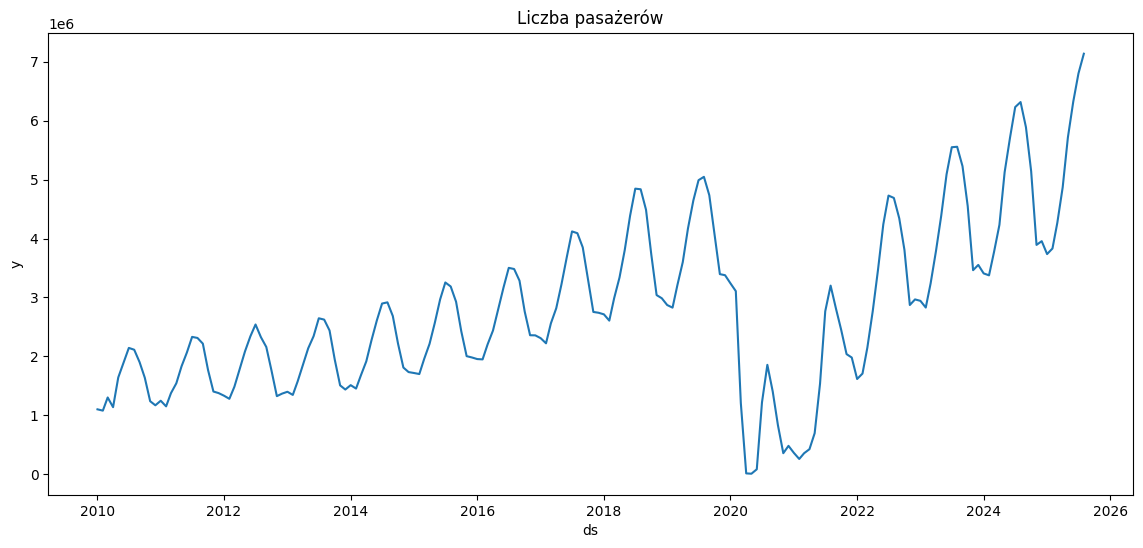

In [18]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_prophet, x='ds', y='y')
plt.title('Liczba pasażerów')
plt.show()

1. DEKOMPOZYCJA WYKAZALA ZE DANE MAJA CHARAKTER MULTIPLIKATYWNY, JEST TREND WZROSTOWY Z ANOMALIA TZN.PANDEMIA, I ZE JEST SEZONOWOSC

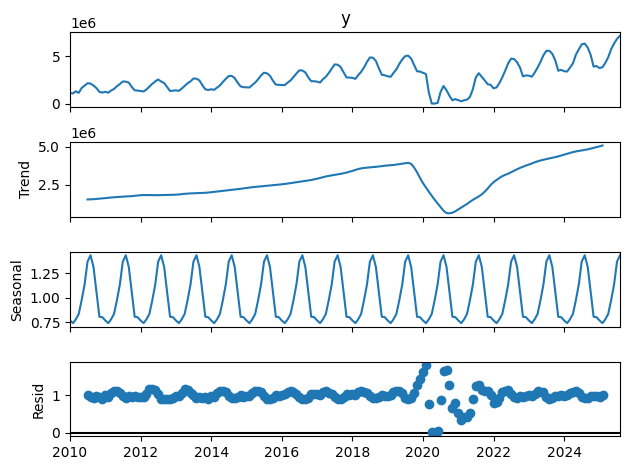

In [20]:
df_prophet_indexed = df_prophet.set_index('ds')['y']
result = seasonal_decompose(df_prophet_indexed, model='multiplicative', period=12)
result.plot()
plt.show()

1. MODEL FACEBOOK PROHET, BEZ PARAMETRU LOCKDOWNS


In [ ]:
model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.3, interval_width=0.95)
model.fit(df_prophet)

21:35:35 - cmdstanpy - INFO - Chain [1] start processing
21:35:35 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
future = model.make_future_dataframe(periods=24, freq='MS')
future.tail()

,ds
207,2027-04-01
208,2027-05-01
209,2027-06-01
210,2027-07-01
211,2027-08-01


In [46]:
forecast = model.predict(future) 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
207,2027-04-01,6.579273e+06,4.789731e+06,8.405386e+06
208,2027-05-01,7.079254e+06,5.171391e+06,9.087718e+06
209,2027-06-01,7.601449e+06,5.676408e+06,9.761929e+06
210,2027-07-01,8.014380e+06,5.778332e+06,1.018173e+07
211,2027-08-01,8.084481e+06,5.753344e+06,1.038632e+07


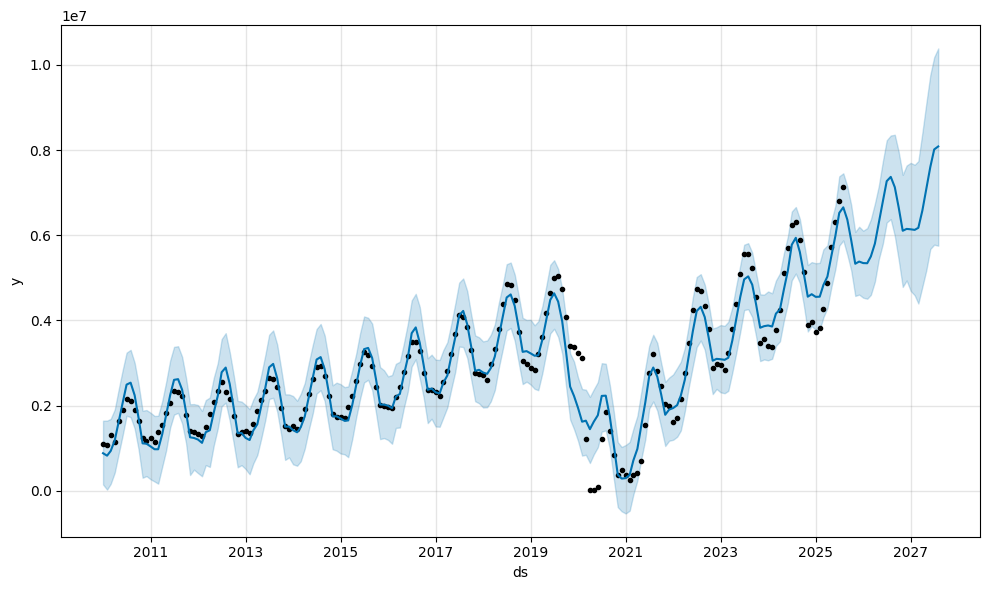

In [47]:
fig1 = model.plot(forecast)

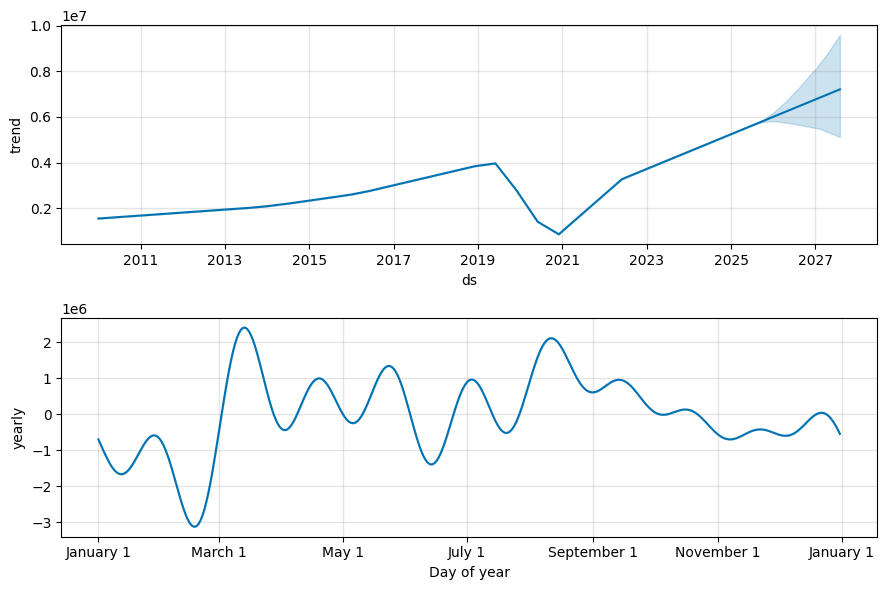

In [48]:
fig2 = model.plot_components(forecast)

In [86]:
# Szybka walidacja modelu bazowego dla porównania
df_cv_baseline = cross_validation(model, initial='3650 days', period='365 days', horizon='730 days')
df_p_baseline = performance_metrics(df_cv_baseline)
print("Metryki walidacji:")
display(df_p_baseline[['mae', 'rmse', 'mape']].mean())

  0%|          | 0/4 [00:00<?, ?it/s]15:52:45 - cmdstanpy - INFO - Chain [1] start processing
15:52:45 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:00,  9.14it/s]15:52:45 - cmdstanpy - INFO - Chain [1] start processing
15:52:45 - cmdstanpy - INFO - Chain [1] done processing
15:52:45 - cmdstanpy - INFO - Chain [1] start processing
15:52:45 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:00<00:00, 11.51it/s]15:52:45 - cmdstanpy - INFO - Chain [1] start processing
15:52:45 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:00<00:00, 11.53it/s]


Metryki walidacji:


mae     1.294560e+06
rmse    1.435063e+06
mape    6.085117e-01
dtype: float64

In [87]:
summary = df_p_baseline[['mae', 'rmse', 'mape']].mean()
print(f"Średni błąd MAE: {summary['mae']:,.0f} pasażerów")
print(f"Średni błąd RMSE: {summary['rmse']:,.0f} pasażerów")
print(f"Średni błąd MAPE: {summary['mape']*100:.2f}%")

Średni błąd MAE: 1,294,560 pasażerów
Średni błąd RMSE: 1,435,063 pasażerów
Średni błąd MAPE: 60.85%


1. MODEL FACEBOOK PROPHET Z UWZGLĘDNIENIEM PARAMETRU LOCKDDOWNS, JAKO 
ZDARZENIE SPECJALNE, SA ZAPISANE 3 FALE LOCKDOWNU CO POZWALA MODELOWI ODSEPAROWAC EKSTREMALNE SPADKI OD STALEGO TRENDU I SEZONOWOSCI 

In [55]:
df_lockdowns = df_prophet[['ds','y']].copy()

In [56]:
df_lockdowns.head()

,ds,y
0,2010-01-01,1102669
1,2010-02-01,1080644
2,2010-03-01,1303859
3,2010-04-01,1139301
4,2010-05-01,1643950


In [145]:
lockdowns = pd.DataFrame({
  'holiday': 'lockdown',
  'ds': pd.to_datetime([
      '2020-03-01',  # Pierwsza fala i całkowite uziemienie lotów (marzec-maj)
      '2020-11-01',  # Druga fala (jesień/zima 2020)
      '2021-03-01'   # Trzecia fala (wiosna 2021)
  ]),
  'lower_window': 0,
  'upper_window': [90, 120, 60], # Liczba dni trwania wpływu danej fali
})

m = Prophet(holidays=lockdowns, yearly_seasonality=True, interval_width=0.95)
m.fit(df_lockdowns)

16:35:24 - cmdstanpy - INFO - Chain [1] start processing
16:35:24 - cmdstanpy - INFO - Chain [1] done processing


In [146]:
# 1. Tworzymy ramkę dla przyszłych dat
future = m.make_future_dataframe(periods=24, freq='MS')

# 2. Generujemy prognozę
forecast = m.predict(future)

# 3. Wyświetlamy tabelę z wynikami (to co zaproponowałeś - bardzo git!)
print("Prognozowane wartości na najbliższe miesiące:")
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Prognozowane wartości na najbliższe miesiące:


,ds,yhat,yhat_lower,yhat_upper
207,2027-04-01,5.511902e+06,4.046615e+06,6.890306e+06
208,2027-05-01,5.815549e+06,4.471978e+06,7.165959e+06
209,2027-06-01,6.202674e+06,4.743940e+06,7.536197e+06
210,2027-07-01,6.610770e+06,5.214285e+06,7.930841e+06
211,2027-08-01,6.660265e+06,5.248112e+06,8.135077e+06


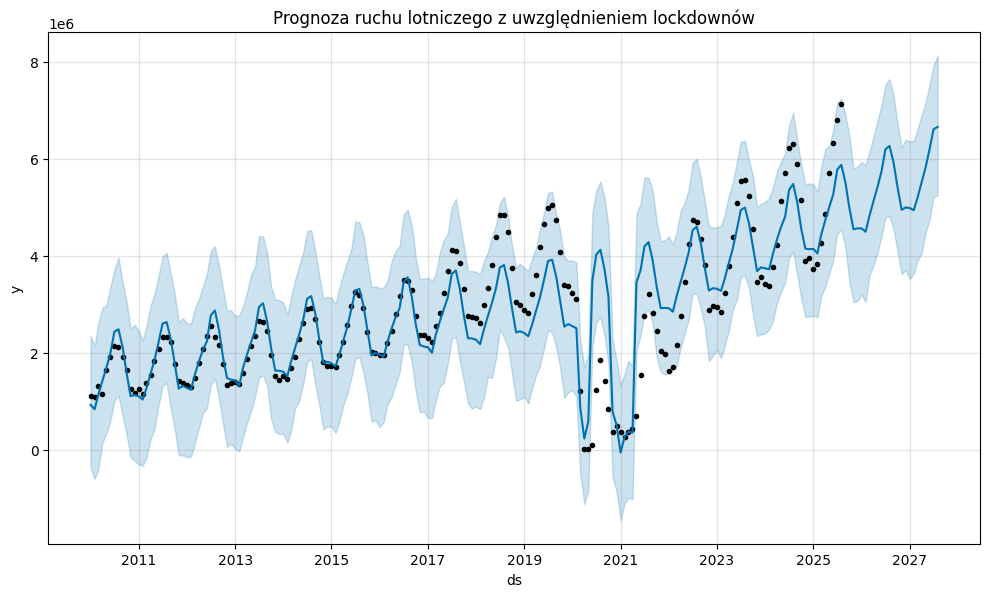

In [147]:
fig_final = m.plot(forecast)
plt.title('Prognoza ruchu lotniczego z uwzględnieniem lockdownów')
plt.show()

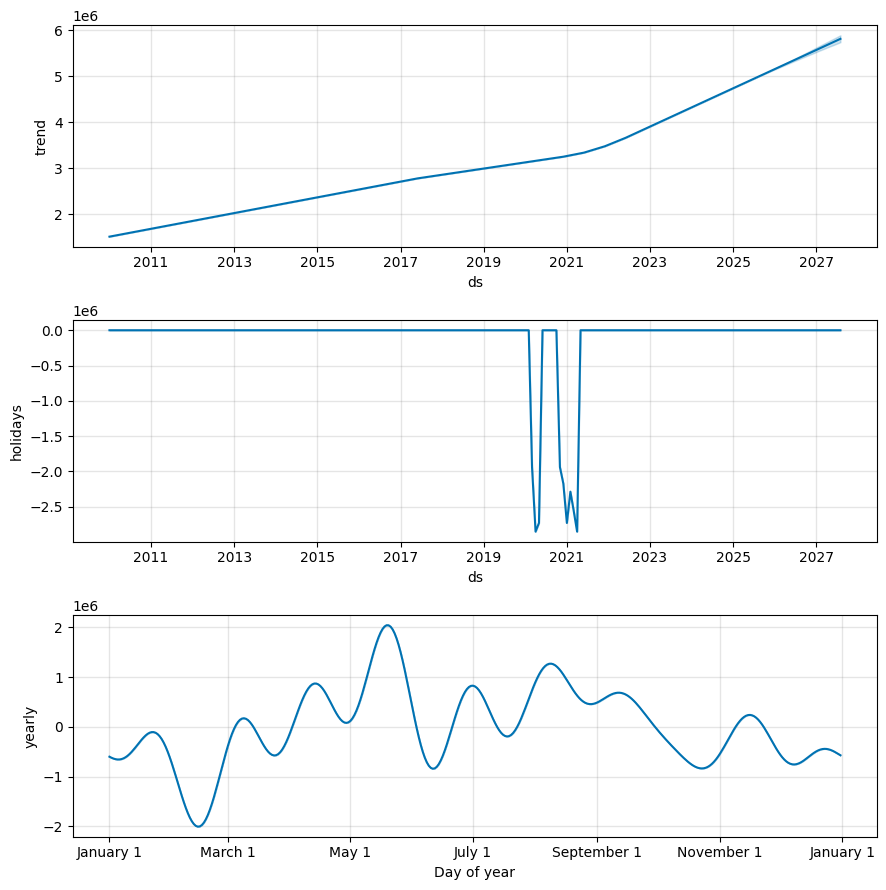

In [148]:
fig_comp = m.plot_components(forecast)
plt.show()

In [149]:
df_cv = cross_validation(m, initial='3650 days', period='365 days', horizon='730 days')
df_p = performance_metrics(df_cv)

print("Metryki walidacji modelu z lockdownami:")
display(df_p[['mae', 'rmse', 'mape']].mean())

  0%|          | 0/4 [00:00<?, ?it/s]16:35:35 - cmdstanpy - INFO - Chain [1] start processing
16:35:35 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:00,  9.92it/s]16:35:35 - cmdstanpy - INFO - Chain [1] start processing
16:35:35 - cmdstanpy - INFO - Chain [1] done processing
16:35:35 - cmdstanpy - INFO - Chain [1] start processing
16:35:35 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:00<00:00, 12.57it/s]16:35:35 - cmdstanpy - INFO - Chain [1] start processing
16:35:35 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:00<00:00, 12.37it/s]


Metryki walidacji modelu z lockdownami:


mae     1.294560e+06
rmse    1.435063e+06
mape    6.085117e-01
dtype: float64

In [150]:
summary = df_p[['mae', 'rmse', 'mape']].mean()
print(f"Średni błąd MAE: {summary['mae']:,.0f} pasażerów")
print(f"Średni błąd RMSE: {summary['rmse']:,.0f} pasażerów")
print(f"Średni błąd MAPE: {summary['mape']*100:.2f}%")

Średni błąd MAE: 1,294,560 pasażerów
Średni błąd RMSE: 1,435,063 pasażerów
Średni błąd MAPE: 60.85%


1. WALIDACJA MODELU 
- ZROBIONA ZOSTALA WALIDACJA KRZYZOWA DLA HORYZONTU 730 DNI
MAE - OK. 1,29 MLN
MAPE - OK. 60%

2. WNIOSKI: 
- ANALIZA WYKAZALA ZE DANE DOT. LICZBY PASAZERÓW MAJĄ WYRAŹNY TREND DŁUGOTERMINOWY ORAZ SILNĄ SEZONOWOŚĆ ROCZNĄ.
- MODEL PROPHET KTÓRY ZOSTAŁ ZASTOSOWANY, SCZEGÓLNIE TEN UWZGLĘDNIAJĄCY LOCKDOWNY, POZWOLIŁ NA LEPSZE ODWZOROWANIE RZECZYWISTYCH ZMIAN W DANYCH W OKRESIE PANDEMI
- MIMO STOSUNKOWO WYSOKIEGO BŁĘDU PROCENTOWEGO PROGNOZY, MODEL DOBRZE ODDAJE OGÓLNY KIERUNEK ZMIAN ORAZ SEZONOWSCI. JEGO ZASTOSWOANIE DO DOKŁADNYCH PROGNOZ WYMAGA DALSZEGO MANIPULOWANIA PARAMETRAMI